In [22]:
import numpy as np
import pandas as pd
from dfply import *
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import timedelta
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철')

# 데이터 정제 시 필요한 모듈들
import src.subjectlist_alignment.pairing as pairing   # 삽관 발관 페어링 관련 모듈
from src.subjectlist_alignment import reintubation as rnt   # 재삽관 시간 계산 관련 모듈
from src.subjectlist_alignment import imputation as imp   # 결측치 대체 관련 모듈
from src.subjectlist_alignment import subject_classification as cls

import src.utils.utils as utils   # 기타 유틸리티 모듈
import src.data_extraction.access_database as db   # DB 연결 관련 모듈

In [16]:
# 변수를 붙일 subjectlist 데이터 가져오기

data_dir = '../outputs/subjectlist1.csv'
subjectlist1 = pd.read_csv(data_dir, index_col=0)

# datetime 변환
time_cols = ['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime', 'reintubation_eventtime']
subjectlist1 = utils.to_datetime(subjectlist1, time_cols)
print(subjectlist1.shape)

# 데이터 단순화
cols = ['subject_id', 'hadm_id', 'stay_id', 'admittime', 'dischtime', 'deathtime', 'class']
# unique_hadms = list(subjectlist1.hadm_id.unique())
trimmed_table = subjectlist1[cols]

trimmed_table

Converted admittime to datetime.
Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
Converted reintubation_eventtime to datetime.
(9003, 29)


,subject_id,hadm_id,stay_id,admittime,dischtime,deathtime,class
0,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,nonfailure
1,10003400,23559586,38383343,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,nonfailure
2,10004401,27939719,31202136,2144-04-11 03:31:00,2144-04-13 17:31:00,NaT,nonfailure
3,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,failure
4,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,nonfailure
...,...,...,...,...,...,...,...
8998,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure
8999,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure
9000,19999068,21606769,30143796,2161-08-24 04:10:00,2161-09-02 19:00:00,NaT,nonfailure
9001,19999442,26785317,32336619,2148-11-19 10:00:00,2148-12-04 16:25:00,NaT,nonfailure


In [3]:
# # DB 연결 테이블 후 가져오기

# database_config = {'database': 'mimic4',
#  'user': 'postgres',
#  'password': '1234',
#  'host': 'localhost',
#  'port': 5432}

# tables_query = {
#     'apsiii': "select * from mimiciv_derived.apsiii;"
#                 }


# db.print_config_info(database_config, tables_query)
# conn = db.connect_to_database(database_config)
# dataframes = db.retrieve_data(conn, tables_query)
# db.disconnect_database(conn)

# # pg_tables = dataframes['pg_tables']
# # patients = dataframes['patients']
# # d_items = dataframes['d_items']

# apsiii = dataframes['apsiii']



### aps iii

In [5]:
apsiii = pd.read_csv('../outputs/apsiii.csv')
apsiii

,subject_id,hadm_id,stay_id,apsiii,apsiii_prob,hr_score,mbp_score,temp_score,resp_rate_score,pao2_aado2_score,...,wbc_score,creatinine_score,uo_score,bun_score,sodium_score,albumin_score,bilirubin_score,glucose_score,acidbase_score,gcs_score
0,12466550,23998182,30000153,44,0.086546,7.0,6.0,0.0,0.0,NaN,...,0.0,0.0,5.0,7.0,0.0,NaN,NaN,0.0,1.0,15.0
1,13180007,27543152,30000213,44,0.086546,0.0,7.0,0.0,6.0,NaN,...,0.0,7.0,0.0,11.0,2.0,0.0,0.0,5.0,NaN,3.0
2,18421337,22413411,30000484,79,0.331267,1.0,15.0,2.0,8.0,NaN,...,5.0,0.0,5.0,11.0,0.0,0.0,0.0,0.0,NaN,29.0
3,12207593,22795209,30000646,29,0.044555,1.0,15.0,0.0,9.0,NaN,...,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
4,12980335,23552849,30001148,65,0.203575,0.0,7.0,2.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,NaN,NaN,0.0,1.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73176,16180713,20178444,39999301,46,0.094316,0.0,10.0,2.0,8.0,0.0,...,0.0,4.0,7.0,7.0,0.0,0.0,0.0,5.0,0.0,0.0
73177,15498623,27161460,39999384,50,0.111749,0.0,15.0,0.0,8.0,NaN,...,0.0,7.0,5.0,12.0,0.0,NaN,NaN,0.0,NaN,0.0
73178,11256534,26910235,39999552,81,0.352529,7.0,15.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2.0,48.0
73179,15403458,25335698,39999562,14,0.022437,5.0,4.0,0.0,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [25]:
apsiii.stay_id.nunique()

73181

In [7]:
apsiii.columns  # apsiii (심각도 점수), apsiii_prob (사망 확률 값) 두 값이 중요.

Index(['subject_id', 'hadm_id', 'stay_id', 'apsiii', 'apsiii_prob', 'hr_score',
       'mbp_score', 'temp_score', 'resp_rate_score', 'pao2_aado2_score',
       'hematocrit_score', 'wbc_score', 'creatinine_score', 'uo_score',
       'bun_score', 'sodium_score', 'albumin_score', 'bilirubin_score',
       'glucose_score', 'acidbase_score', 'gcs_score'],
      dtype='object')

In [38]:
# 중복값?
apsiii_duplicates = apsiii.duplicated(subset=['stay_id'], keep=False)
apsiii_duplicate_count = apsiii_duplicates.sum()
apsiii_duplicate_count

0

In [20]:
# 테이블 머지
sl = pd.merge(trimmed_table, apsiii[['subject_id', 'hadm_id', 'stay_id', 'apsiii', 'apsiii_prob']], on=['subject_id', 'hadm_id', 'stay_id'], how='left')
sl

,subject_id,hadm_id,stay_id,admittime,dischtime,deathtime,class,apsiii,apsiii_prob
0,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,nonfailure,51,0.116527
1,10003400,23559586,38383343,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,nonfailure,103,0.606299
2,10004401,27939719,31202136,2144-04-11 03:31:00,2144-04-13 17:31:00,NaT,nonfailure,46,0.094316
3,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,failure,101,0.583525
4,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,nonfailure,101,0.583525
...,...,...,...,...,...,...,...,...,...
8998,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,32,0.050995
8999,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,32,0.050995
9000,19999068,21606769,30143796,2161-08-24 04:10:00,2161-09-02 19:00:00,NaT,nonfailure,50,0.111749
9001,19999442,26785317,32336619,2148-11-19 10:00:00,2148-12-04 16:25:00,NaT,nonfailure,28,0.042586


In [36]:
apsiii_mean = sl.apsiii.mean()
apsiii_median = sl.apsiii.median()
apsiii_std = sl.apsiii.std()
apsiii_min = sl.apsiii.min()
apsiii_max = sl.apsiii.max()

print('APS III')
print(f'apsiii_mean: {apsiii_mean}')
print(f'apsiii_median: {apsiii_median}')
print(f'apsiii_std: {apsiii_std}')
print(f'apsiii_range: {apsiii_min} - {apsiii_max}')

APS III
apsiii_mean: 57.09896701099633
apsiii_median: 54.0
apsiii_std: 24.250215748102217
apsiii_range: 4 - 178


In [13]:
apsiii.apsiii.mean()

43.159590604118556

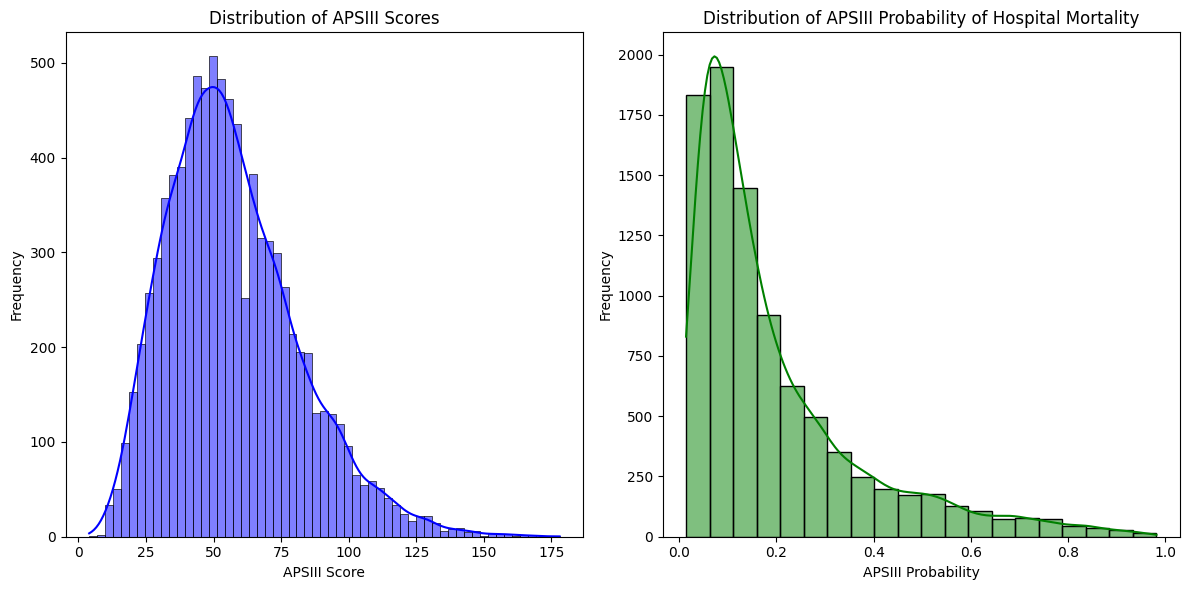

In [23]:
# Visualize the distribution of 'apsiii'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # First subplot in a 1x2 grid
sns.histplot(sl['apsiii'], kde=True, color='blue', edgecolor='black')
plt.title('Distribution of APSIII Scores')
plt.xlabel('APSIII Score')
plt.ylabel('Frequency')

# Visualize the distribution of 'apsiii_prob'
plt.subplot(1, 2, 2)  # Second subplot in a 1x2 grid
sns.histplot(sl['apsiii_prob'], kde=True, color='green', bins=20, edgecolor='black')
plt.title('Distribution of APSIII Probability of Hospital Mortality')
plt.xlabel('APSIII Probability')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

In [24]:
sapsii = pd.read_csv('../outputs/sapsii.csv')
sapsii

,subject_id,hadm_id,stay_id,starttime,endtime,sapsii,sapsii_prob,age_score,hr_score,sysbp_score,...,uo_score,bun_score,wbc_score,potassium_score,sodium_score,bicarbonate_score,bilirubin_score,gcs_score,comorbidity_score,admissiontype_score
0,14046553,20000094,35605481,2150-03-02 15:19:31,2150-03-03 15:19:31,98,0.982729,18,11.0,13.0,...,11.0,10.0,0.0,0.0,0.0,3.0,0.0,26.0,0,6
1,14990224,20000147,30503572,2121-08-30 16:33:54,2121-08-31 16:33:54,35,0.166523,15,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0,6
2,17913090,20000351,30593599,2145-06-13 20:10:27,2145-06-14 20:10:27,24,0.058153,7,0.0,0.0,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,6
3,16788749,20000808,30610654,2180-01-17 19:32:10,2180-01-18 19:32:10,17,0.025876,7,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0,8
4,16788749,20000808,35191063,2180-01-12 22:07:00,2180-01-13 22:07:00,26,0.071716,7,0.0,0.0,...,11.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73176,14641622,29999186,32199257,2135-07-12 01:51:00,2135-07-13 01:51:00,30,0.106398,7,0.0,5.0,...,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0,8
73177,10053207,29999444,31112026,2199-12-14 19:52:26,2199-12-15 19:52:26,26,0.071716,7,4.0,0.0,...,0.0,6.0,0.0,0.0,0.0,3.0,0.0,0.0,0,6
73178,13478841,29999498,33874605,2188-05-13 12:03:00,2188-05-14 12:03:00,34,0.152870,16,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,9,6
73179,10355856,29999625,36975675,2157-11-07 11:51:00,2157-11-08 11:51:00,32,0.128048,12,0.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,0,8


starttime, endtime의 존재는 aps iii와 계산 방식의 차이로 인한 것 같음

In [26]:
sapsii.stay_id.nunique()

73181

In [27]:
sapsii.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'starttime', 'endtime', 'sapsii',
       'sapsii_prob', 'age_score', 'hr_score', 'sysbp_score', 'temp_score',
       'pao2fio2_score', 'uo_score', 'bun_score', 'wbc_score',
       'potassium_score', 'sodium_score', 'bicarbonate_score',
       'bilirubin_score', 'gcs_score', 'comorbidity_score',
       'admissiontype_score'],
      dtype='object')

In [39]:
# 중복값?
sapsii_duplicates = sapsii.duplicated(subset=['stay_id'], keep=False)
sapsii_duplicate_count = sapsii_duplicates.sum()
sapsii_duplicate_count

0

In [29]:
# 테이블 머지
sl2 = pd.merge(sl, sapsii[['subject_id', 'hadm_id', 'stay_id', 'sapsii', 'sapsii_prob']], on=['subject_id', 'hadm_id', 'stay_id'], how='left')
sl2

,subject_id,hadm_id,stay_id,admittime,dischtime,deathtime,class,apsiii,apsiii_prob,sapsii,sapsii_prob
0,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,nonfailure,51,0.116527,44,0.326364
1,10003400,23559586,38383343,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,nonfailure,103,0.606299,83,0.941142
2,10004401,27939719,31202136,2144-04-11 03:31:00,2144-04-13 17:31:00,NaT,nonfailure,46,0.094316,43,0.305597
3,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,failure,101,0.583525,65,0.769396
4,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,nonfailure,101,0.583525,65,0.769396
...,...,...,...,...,...,...,...,...,...,...,...
8998,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,32,0.050995,55,0.575439
8999,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,32,0.050995,55,0.575439
9000,19999068,21606769,30143796,2161-08-24 04:10:00,2161-09-02 19:00:00,NaT,nonfailure,50,0.111749,44,0.326364
9001,19999442,26785317,32336619,2148-11-19 10:00:00,2148-12-04 16:25:00,NaT,nonfailure,28,0.042586,20,0.037205


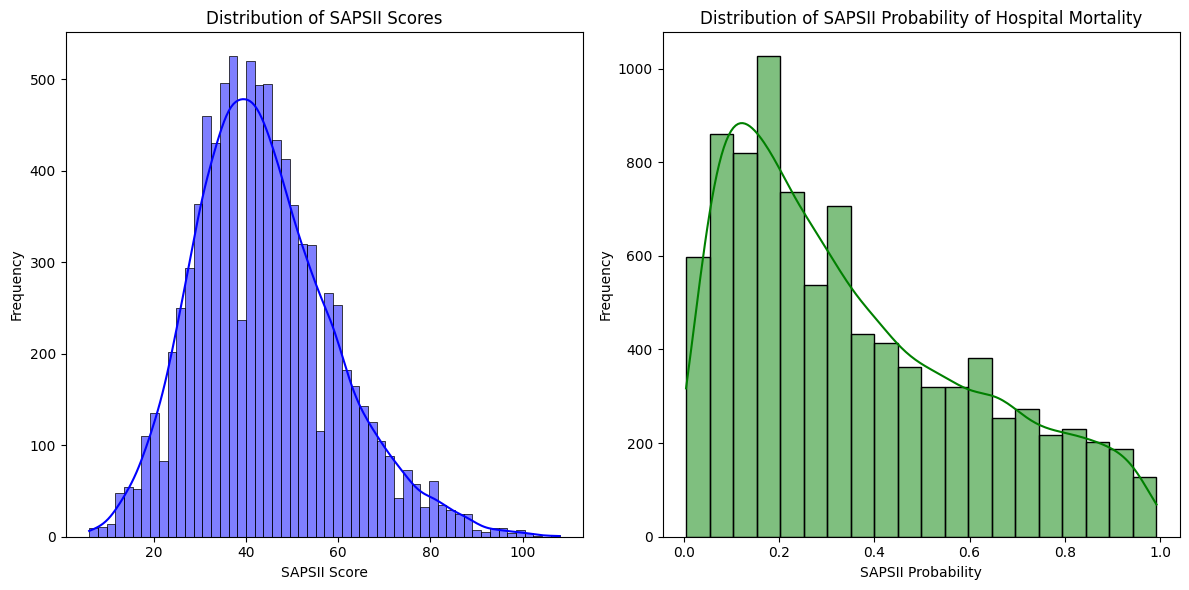

In [31]:
# Visualize the distribution of 'apsiii'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # First subplot in a 1x2 grid
sns.histplot(sl2['sapsii'], kde=True, color='blue', edgecolor='black')
plt.title('Distribution of SAPSII Scores')
plt.xlabel('SAPSII Score')
plt.ylabel('Frequency')

# Visualize the distribution of 'apsiii_prob'
plt.subplot(1, 2, 2)  # Second subplot in a 1x2 grid
sns.histplot(sl2['sapsii_prob'], kde=True, color='green', bins=20, edgecolor='black')
plt.title('Distribution of SAPSII Probability of Hospital Mortality')
plt.xlabel('SAPSII Probability')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

In [37]:
sapsii_mean = sl2.sapsii.mean()
sapsii_median = sl2.sapsii.median()
sapsii_std = sl2.sapsii.std()
sapsii_min = sl2.sapsii.min()
sapsii_max = sl2.sapsii.max()

print('SAPS II')
print(f'sapsii_mean: {sapsii_mean}')
print(f'sapsii_median: {sapsii_median}')
print(f'sapsii_std: {sapsii_std}')
print(f'sapsii_range: {sapsii_min} - {sapsii_max}')

SAPS II
sapsii_mean: 43.96889925580362
sapsii_median: 42.0
sapsii_std: 15.233913729047718
sapsii_range: 6 - 108
